In [107]:
%reload_ext autoreload
%autoreload 2

import torch

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from datasets import *
from models import *
from losses import *

In [108]:
device = 'cpu'

In [109]:
data_generator = GaussianDataset(
    [lambda x: -3 * x, lambda x: 3 * x],
    torch.tensor([0.5, 0.5], dtype=torch.float32),
    torch.tensor([0.5, 0.5], dtype=torch.float32),
    poly=2,
    device=device
)

data_generator.generate_data(100000, 1)
train_loader = torch.utils.data.DataLoader(data_generator, batch_size=5000, shuffle=True)

print('mean:', round(torch.mean(data_generator.y).item(), 2), 'std:', round(torch.std(data_generator.y).item(), 2))

data_generator.generate_data(1000, 1)
test_loader = torch.utils.data.DataLoader(data_generator, batch_size=1000, shuffle=True)

mean: -0.01 std: 1.8


likelihood: tensor(1.4544)
log_prior: tensor(1.9332)
log_p_q: tensor(1.5407)
elbo: tensor(2.2224)


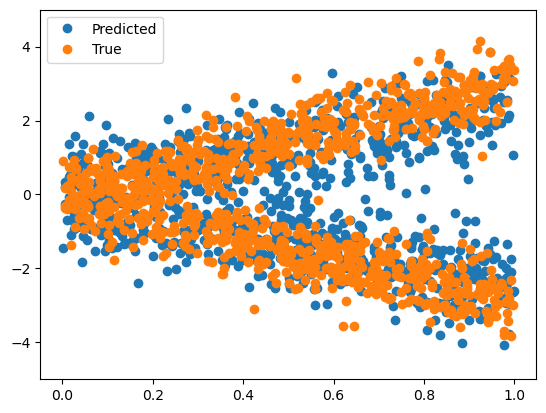

In [110]:
model_medium = GMNN(2, 2, 2, 20).to(device)
epochs = 2000
lr = 0.01
optim = torch.optim.Adam(model_medium.parameters(), lr=lr)
loss_fn = GaussianMixtureLoss(torch.mean(data_generator.y).item(), torch.std(data_generator.y).item(), device=device)

for epoch in range(epochs):
    model_medium.train()
    if epoch % 100 == 0:
        print('Epoch:', epoch, 'to', epoch+100, 'Loss:', round(loss.item(), 2), end='\r', flush=True)

    for X, y in train_loader:
        optim.zero_grad()
        y_pred, mu, log_var, weights = model_medium(X)
        loss = loss_fn(y_pred, y, mu, log_var, weights)
        loss.backward()
        optim.step()

    if epoch % 500 == 0:
        lr /= 2
        optim = torch.optim.Adam(model_medium.parameters(), lr=lr)
        
    if epoch % 100 == 0:
        clear_output(wait=True)
        model_medium.eval()
        X_test_list, y_test_list, y_pred_list, mu_pred_list = [], [], [], []
        with torch.no_grad():
            for X, y in test_loader:
                X_test_list += X[:, 0].flatten().tolist()
                y_test_list += y.flatten().tolist()
                y_pred, mu, log_var, weights = model_medium(X)
                y_pred_list += y_pred.flatten().tolist()
                mu_pred_list += mu.mean(dim=1).flatten().tolist()
                loss_fn.loss_eval(y_pred, y, mu, log_var, weights)

        plt.plot(X_test_list, y_pred_list, 'o', label='Predicted')
        plt.plot(X_test_list, y_test_list, 'o', label='True')
        # plt.plot(X_test_list, mu_pred_list, 'o', label='Mean')
        # plt.plot(X_test_list, np.array(X_test_list)*5, label='True')
        plt.legend()
        plt.ylim(-5, 5)
        plt.show()

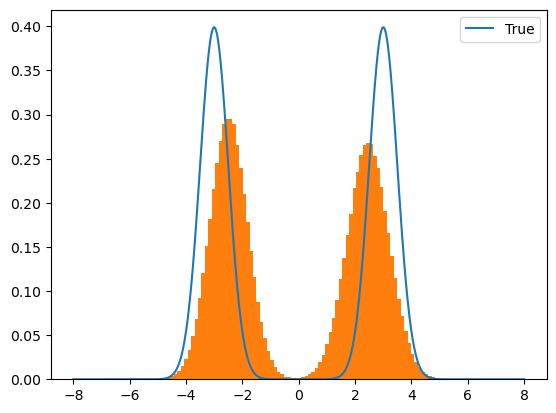

In [111]:
x = 1.
X = torch.full((1000000, 2), x)
y = np.linspace(-8, 8, 1000)
y_distr = data_generator.y_curve(x, y)
with torch.no_grad():
    y_pred, mu, log_var, weights = model_medium(X)

plt.plot(y, y_distr, label='True')
plt.hist(y_pred.flatten(), bins=100, density=True)
plt.legend()
plt.show()